
🌲 决策树回归模型评估结果：
R²: 0.609
MSE: 50356.11


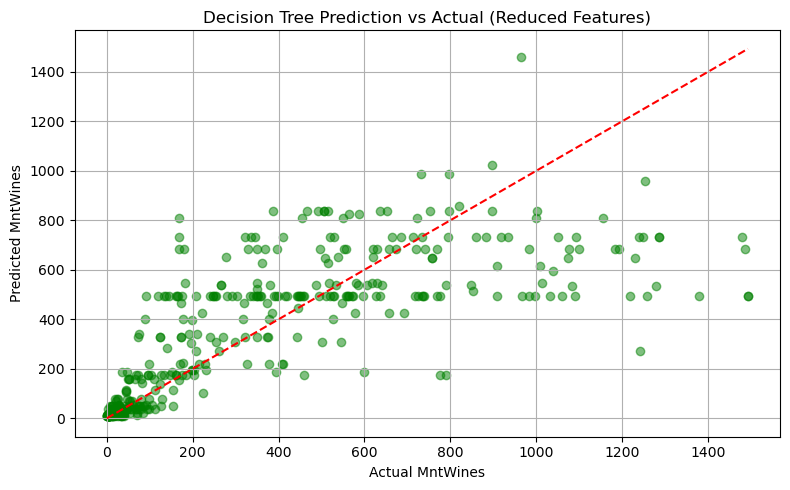

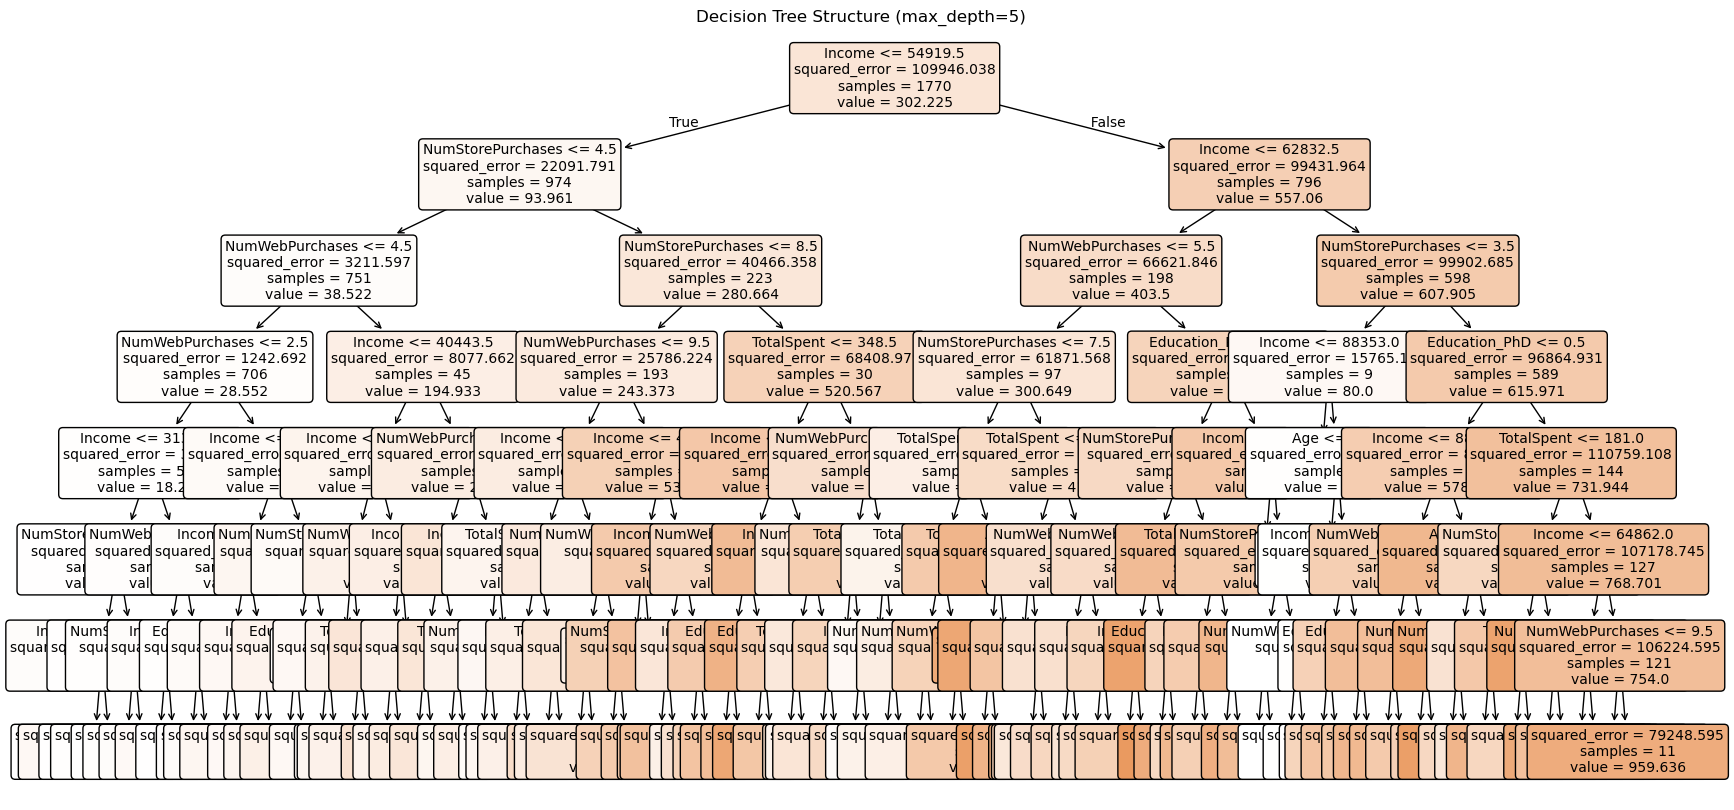

In [5]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# === 预处理部分（略） ===
df = pd.read_csv('marketing_campaign_NEW.csv', sep='\t')
df['Age'] = 2025 - df['Year_Birth']
df = df[df['Age'] <= 100]
df = df.dropna(subset=['Income'])
df = pd.get_dummies(df, columns=['Education', 'Marital_Status'], drop_first=True)
df['TotalSpent'] = df[[
    'MntFruits', 'MntMeatProducts', 'MntFishProducts',
    'MntSweetProducts', 'MntGoldProds'
]].sum(axis=1)
features = [
    'Age', 'Income', 'Kidhome', 'Teenhome', 'Recency',
    'NumWebPurchases', 'NumStorePurchases', 'NumDealsPurchases',
    'TotalSpent'
] + [col for col in df.columns if col.startswith('Education_') or col.startswith('Marital_Status_')]
target = 'MntWines'
# 设置过滤阈值
Setting_Amount = 0  # 你可以改成 100、200 等

# 计算总消费（包括 MntWines）
df['TotalSpendingAll'] = df[[
    'MntWines', 'MntFruits', 'MntMeatProducts',
    'MntFishProducts', 'MntSweetProducts', 'MntGoldProds'
]].sum(axis=1)

# 筛选出活跃客户（消费额大于 Setting_Amount）
df_active = df[df['TotalSpendingAll'] >= Setting_Amount].copy()
# 替代原本的 df --> df_active 后进行建模
X = df_active[features]
y = df_active[target]
# 👉 第一步：用原始数据训练一次，提取 feature importance
tree_init = DecisionTreeRegressor(max_depth=7, random_state=42)
tree_init.fit(X, y)

# 👉 第二步：按重要性筛选特征（可调节阈值）
importances = tree_init.feature_importances_
features_all = X.columns
coef_table = pd.DataFrame({
    "Feature": features_all,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# 设置阈值，只保留重要性 > 0.01 的特征
important_features = coef_table[coef_table['Importance'] > 0.01]['Feature'].tolist()

X_reduced = X[important_features]
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# 👉 创建决策树回归器（控制最大深度避免过拟合）
tree_model = DecisionTreeRegressor(max_depth=7, random_state=42)
tree_model.fit(X_train, y_train)

# 👉 预测与评估
y_pred = tree_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"\n🌲 决策树回归模型评估结果：")
print(f"R²: {r2:.3f}")
print(f"MSE: {mse:.2f}")

# 👉 可视化预测效果（散点图）
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.5, color='green')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual MntWines")
plt.ylabel("Predicted MntWines")
plt.title("Decision Tree Prediction vs Actual (Reduced Features)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 👉 可选：画出整棵树结构（适合报告插图）
plt.figure(figsize=(20, 10))
plot_tree(tree_model, feature_names=X_reduced.columns, filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree Structure (max_depth=5)")
plt.show()